# Bag of visual words

Bag of Visual Words considers the problem of finding  similar images. Typically, we aim at finding images within a database that are similar to a given query image.

One way to compare images is pixel-by-pixel. A pixel-by-pixel comparison has the disadvantage that certain types of changes such as those caused by a change in the viewpoint cannot be handled well. Furthermore, a large number of comparisons need to be executed as each pixel of the images must be compared.

To not compare images pixel by pixel, we can use so-called "visual words" to describe images. The concept has its origins in the text retrieval community and thus the terms word and document are often used. The Bag of Visual Words concept assumes that an image can be described by a set of visual words, i.e., visual features such as SIFT descriptors. A visual word is often a "generalized" feature descriptor, most frequently it is a mean value of a cluster of similar visual features. We furthermore restrict the set of visual words that we will consider in the comparison to a dictionary. 

So, we can describe an image as a set of visual words and then aggregate the occurrences of these words in a histogram per image. By comparing these image histograms instead of the original images, we can figure out which images are visually similar. In the Bag of Visual Words notation, these are images with a small histogram difference.

There is, however, a problem with this basic approach. It occurs when the visual words occur in a lot or every image of the image database. From the histogram perspective, it is impossible to distinguish which images are similar and which are not as the histograms are not very expressive. To address this problem, we can apply the so-called TF-IDF (Term Frequency - Inverse Document Frequency) reweighting approach. It reweights every bin of a histogram and will downweight the "uninformative" words (i.e., features that occur in a lot of images/everywhere) and enhance the importance of rare words.

In this notebook, we are going to look at the example of how the TF-IDF reweighting works.


## TF-IDF weighting
Let's assume we already have a bag of visual words for our images and we have 4 images that are represented through image histograms. In the example below, image 0 and image 3 are similar to each other. Thus, we expect the matching algorithm to report them as similar. Every reweighted word in the histogram can be computed using the TF-IDF formula given by
$$
t_i = \frac{n_{id}}{n_d}\log \frac{N}{n_i}
$$
where 
* $n_{id}$ - occurance of word $i$ in a document (image) $d$;
* $n_d$ total number of words in a document $d$;
* $n_i$ number of documents (images in the database) that contain the word $i$
* $N$ number of documents (images in the database)



![](data/bag_of_words/histograms.png)

In the example above, image 0 contains 5 blue, 2 pink, 1 green, and no yellow or orange words. The image has in total 8 word occurances. With this information, we can compute the TF $\frac{n_{id}}{n_d}=\frac{5}{8}$.  We can observe that blue word occurs in all 4 images, whereas, for example, the yellow word occurs only in one. Thus, we can compute the overall weighting $t_i$ for all words in every histogram. We can illustrate that by:

![](data/bag_of_words/ti_calculations.png)

The Term frequency basically normalizes histograms to be unit length and Inverse Document frequency weights individual dimension (words) based on their occurance in all images.

After reweighting the histograms, we can notice that the words that occur a lot and everywhere (blue word) gets zero weight everywhere. Interestingly, if a word occurs only once per image but in every image (green) it also get zero weights. The pink words also get more prominent in the histograms. Also just by visual inspection, it is visible more that the histograms for image 0 and image 3 are more similar after reweighting then before.

![](data/bag_of_words/histogram_comparisons.png)




To be definitely confident that reweighting helps, let's look at the cost matrix. The cost matrix is the matrix of all possible histograms comparisons (every image compared against every image). 

Since image 0 and image 3 are similar, we expect the entries `cost_matrix[0][3]` and `cost_matrix[3][0]` to be similar to `cost_matrix[0][0]` and `cost_matrix[3][3]`.

![](data/bag_of_words/cost_matrix_eucl.png)

And indeed they are more similar than the rest of the cost matrix elements.Note, diagonal elements of the matrices result in a distance of 0 because we are comparing identical images.

The cost matrix above was obtained by computing Euclidean distances between the histograms.

One can select another measure to compare histograms, for example cosine similarity or cosine distance (1- cosine smilarity), then the cost matrix will have other values but we can see even higher cost separation between similar and dissimilar images.

![](data/bag_of_words/cost_matrix_cosine.png)


## Visualizing cost matrices

In [2]:
import numpy as np
N = 4
histograms = np.array([ [5,2,1,0,0],
                       [4,0,1,1,0],
                       [3,1,1,0,2],
                       [1,2,1,0,0]])
# Histrogram[0,:] - gets histogram for image 0

In [3]:
import matplotlib.pyplot as plt


def compute_cost_matrices(histograms):
    
    cost_matrix_eucl  = np.zeros((N,N))
    cost_matrix_cos  = np.zeros((N,N))

    for row, hist_row in enumerate(histograms):
        for col, hist_col in enumerate(histograms):
            eucl_dist = np.linalg.norm(hist_row-hist_col)
            cost_matrix_eucl[row, col] = eucl_dist
            cos_sim = np.dot(hist_row, hist_col) / (np.linalg.norm(hist_row)* np.linalg.norm(hist_col))
            cost_matrix_cos[row, col] = cos_sim
    return cost_matrix_eucl, cost_matrix_cos

def plotCostMatrix(ax, cost_matrix, title):
    axh = ax.imshow(cost_matrix, cmap='viridis') 
    plt.colorbar(axh, ax = ax)
    ax.set_title(title)

cm_eucl, cm_cos = compute_cost_matrices(histograms)

In [15]:
## weighing tf-idf function
def reweight_tf_idf(histograms):
    re_hists  = np.zeros(histograms.shape)
    N = histograms.shape[0]
    n_i = np.sum(histograms > 0, axis=0)
    for hist_id in range(histograms.shape[0]):
        n_d  = np.sum(histograms[hist_id])
        for bin_id in range(len(histograms[hist_id])): 
            re_hists[hist_id, bin_id] = histograms[hist_id, bin_id]/ n_d * np.log(N/n_i[bin_id])
#             print(re_hists[hist_id, bin_id], histograms[hist_id, bin_id], n_d, N, n_i[bin_id])
    return re_hists

re_hists = reweight_tf_idf(histograms)
print(re_hists)

[[0.         0.07192052 0.         0.         0.        ]
 [0.         0.         0.         0.23104906 0.        ]
 [0.         0.04109744 0.         0.         0.3960841 ]
 [0.         0.14384104 0.         0.         0.        ]]


In [16]:
weighted_hist = np.array([ [0,0.07,0,0,0],
                           [0,0,0,0.23,0],
                           [0,0.04,0,0,0.4],
                           [0,0.14,0,0,0]])
# Histrogram[0,:] - gets histogram for image 0

[[0.         0.24041631 0.40112342 0.07      ]
 [0.24041631 0.         0.46314145 0.26925824]
 [0.40112342 0.46314145 0.         0.41231056]
 [0.07       0.26925824 0.41231056 0.        ]]


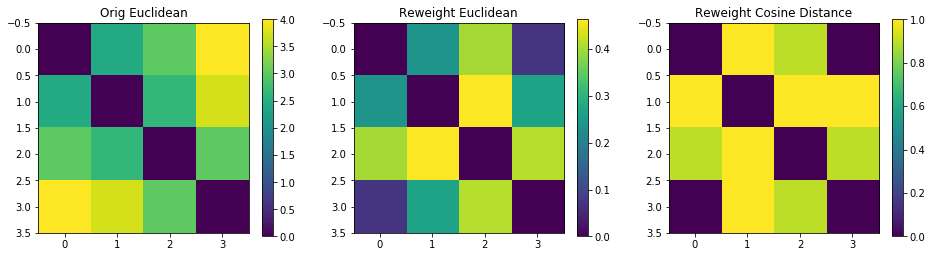

In [17]:
cm_eucl, cm_cos = compute_cost_matrices(histograms)
cm_eucl_w, cm_cos_w = compute_cost_matrices(weighted_hist)

print(cm_eucl_w)



fig, ax = plt.subplots(1,3, figsize=(16,4));

plotCostMatrix(ax[0], cm_eucl, "Orig Euclidean")
plotCostMatrix(ax[1], cm_eucl_w, "Reweight Euclidean")
plotCostMatrix(ax[2], 1- cm_cos_w, "Reweight Cosine Distance")


It seems that reweighted histograms finds similar images outside the diagonal elements, since diagonal and corner pixels have the same color, whereas original histograms struggle to do so. Cosine distance here is $1- \mathrm{cosineSimilarity}$ and it used to show that similar images results in low costs, since for cosine similarity the more similar the images are, the closer they are to 1. Here, we can see that both Euclidean and Cosine distance manage to find the offdiagonal elements, however for cosine distance we can see it more clearly.

## Note on Euclidean and Cosine distance
In previous example, we can see Euclidean distance and cosine similarity being used.
Even though it seems that reweighting of the histograms helps to find similar images, it is not obvious which metric to choose.

Euclidean is $ \sqrt{\sum (x_i -y_i)^2}$

Cosine similarity is $ \frac{x\cdot y}{||x|| ||y||}$

Cosine distance $ 1 -\frac{x\cdot y}{||x|| ||y||}$


For the unit length vectors, squared euclidean distance differs from cosine similarity up to a constant. Let's see this!

Consider having vector $x$ and $y$ with unit length, then
$$
||x-y||^2 = (x-y)^T(x-y) = x^Tx - 2x^Ty + y^Ty = $$
since 
$$||x||=||y||=1$$
we obtain

$$||x-y||^2 = 2- 2x^Ty = 2-2\cos\theta$$


So $\mathrm{dist\_eucl} = \sqrt{2 - 2\mathrm{cos\_similarity}}$.

Let's normalize original histograms such that all the norms of all vectors are equal to 1.


In [11]:
def normToUnitLength(v):
    v_length = np.linalg.norm(v, axis=1)
    v_norm = v
    v_norm = v_norm / v_length[:,np.newaxis]
    return v_norm

# test functions for normToUnitLength
v = np.array([[3,4], [-1,1], [-1,-2]])
v_circle = normToUnitLength(v)
# print(np.linalg.norm(v_circle,axis=1))

v = np.array([[6,6], [2,3], [2,0]])
v_circle = normToUnitLength(v)
# print(np.linalg.norm(v_circle,axis=1))

In [12]:
hist_norm = normToUnitLength(histograms)

## Checking that the norms are actually 1
print(np.linalg.norm(hist_norm,axis=1))


[1. 1. 1. 1.]


Now, we expect that the cost matrix for euclidean distance is the same as a cost matrix for cosine similarity for the normalized histogram. We  expect cost matrix to be the same.

squared Euclidean vs adapted cosine difference
[[0.00000000e+00 4.16333634e-16 1.11022302e-16 3.33066907e-16]
 [4.16333634e-16 4.44089210e-16 0.00000000e+00 2.22044605e-16]
 [1.11022302e-16 0.00000000e+00 0.00000000e+00 1.11022302e-16]
 [3.33066907e-16 2.22044605e-16 1.11022302e-16 4.44089210e-16]]


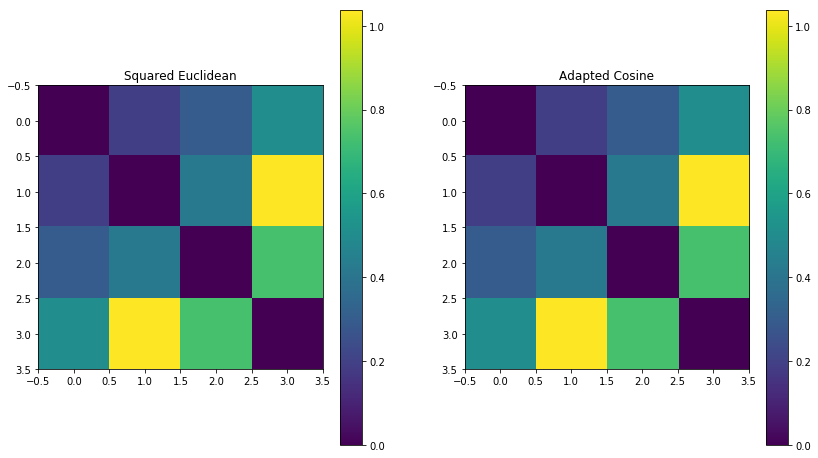

In [13]:
cm_eucl, cm_cos = compute_cost_matrices(histograms)
cm_eucl_norm, cm_cos_norm = compute_cost_matrices(hist_norm)
cm_eucl_w, cm_cos_w = compute_cost_matrices(weighted_hist)

print("squared Euclidean vs adapted cosine difference")
print(np.fabs(cm_eucl_norm**2 - (2 - 2*cm_cos_norm)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))

plotCostMatrix(ax1, cm_eucl_norm**2, "Squared Euclidean")
plotCostMatrix(ax2, 2 - 2*cm_cos_norm, "Adapted Cosine")


OK, they are the same :smile:
But the question stays, what to use Cosine or Euclidean for reweighted histograms?
Let's visualize everything 

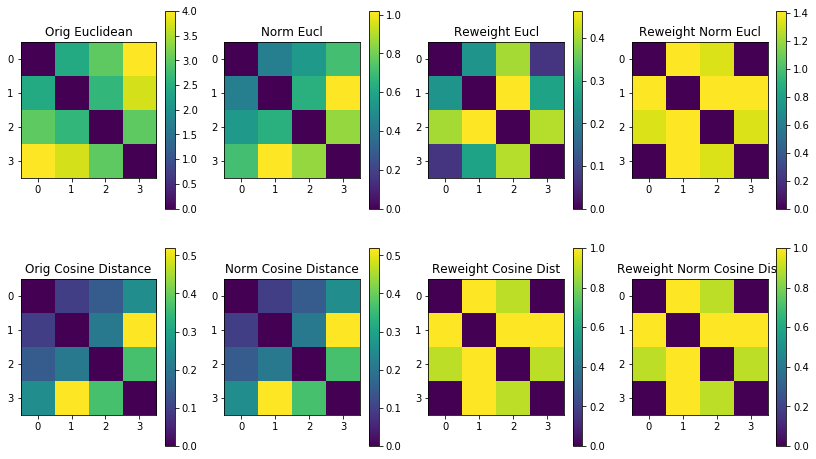

In [14]:
# normalizing reweighted histograms
hist_weigh_norm = normToUnitLength(weighted_hist)
cm_eucl_w_norm, cm_cos_w_norm = compute_cost_matrices(hist_weigh_norm)

fig, axs = plt.subplots(2, 4, figsize=(14,8))

plotCostMatrix(axs[0][0], cm_eucl, "Orig Euclidean")
plotCostMatrix(axs[1][0], 1 - cm_cos, "Orig Cosine Distance")

plotCostMatrix(axs[0][1], cm_eucl_norm, "Norm Eucl")
plotCostMatrix(axs[1][1], 1 - cm_cos_norm, "Norm Cosine Distance")

plotCostMatrix(axs[0][2], cm_eucl_w, "Reweight Eucl")
plotCostMatrix(axs[1][2], 1 - cm_cos_w, "Reweight Cosine Dist")

plotCostMatrix(axs[0][3], cm_eucl_w_norm, "Reweight Norm Eucl")
plotCostMatrix(axs[1][3], 1 - cm_cos_w_norm, "Reweight Norm Cosine Dist")


## Conclusion
So, what do we see?

Basically:

* if we use original histograms, both normalized and not(column 1 and 2) we cannot distinguish similar images except from the ones on the diagonal.

* if we apply **TF-IDF** and use **Cosine Distance** we would be able to find similar images outside diagonal and the difference in more prominent for cosine distance rather than for Euclidean. This would allow to better differentiate between true positives and false positives.

* if we further normalize the TF-IDF reweighted histograms both Eucledian and Cosine distance would give good results.


That's it for now!